In [7]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score

In [8]:
ROOT = Path("dataset")

PATH_NO_LABEL = ROOT / "spotify_songs.csv"
PATH_INT_LABEL = ROOT / "spotify_songs_with_genre_int.csv"

df = pd.read_csv(PATH_INT_LABEL)
df = df.dropna()

print("=== 클래스 분포 ===")
print(df["genre_int"].value_counts())
print("\n=== 데이터셋 크기 ===")
print("총 샘플 수:", len(df))

=== 클래스 분포 ===
genre_int
5    6043
1    5743
0    5507
3    5431
4    5153
2    4951
Name: count, dtype: int64

=== 데이터셋 크기 ===
총 샘플 수: 32828


In [9]:
# === 2. 데이터 전처리 ===

# 특징/레이블 컬럼 정의
num_cols = ["loudness", "danceability", "energy",
            "speechiness", "acousticness", "instrumentalness", "liveness",
            "valence", "tempo", "duration_ms"]
cat_cols = ["key", "mode"]

# 전처리 파이프라인 구성
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

# 데이터 분할
X = df[num_cols + cat_cols]
y = df["genre_int"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 전처리 적용
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
feature_names = num_cols + list(cat_feature_names)

print("전처리 후 특징 수:", X_train_prep.shape[1])

전처리 후 특징 수: 24


In [10]:
# === 6. LightGBM Classifier ===
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=-1,
    verbosity=-1,  # suppress internal LightGBM messages
    n_jobs=-1,
    random_state=42
)

lgb.fit(X_train_prep, y_train)
y_pred_lgb = lgb.predict(X_test_prep)

print("=== LightGBM ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lgb))
print("Macro-F1:", f1_score(y_test, y_pred_lgb, average="macro"))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lgb))

=== LightGBM ===
Accuracy: 0.5619859884252209
Macro-F1: 0.5570200166425794

Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.37      0.37      1101
           1       0.60      0.67      0.63      1149
           2       0.69      0.76      0.72       990
           3       0.49      0.45      0.47      1086
           4       0.50      0.42      0.46      1031
           5       0.69      0.69      0.69      1209

    accuracy                           0.56      6566
   macro avg       0.56      0.56      0.56      6566
weighted avg       0.56      0.56      0.56      6566



Top 3 features by LightGBM importance:
tempo          7892
duration_ms    7413
speechiness    7237
dtype: int32


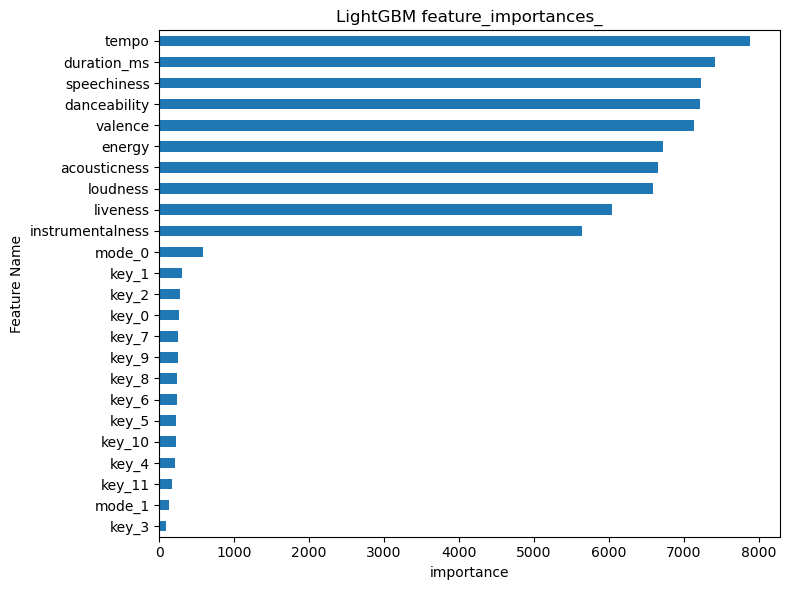

In [11]:
# === 7. Feature importance 분석 (LightGBM + Permutation) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

lgb_importances = pd.Series(lgb.feature_importances_, index=feature_names)

# 중요도를 내림차순으로 정렬합니다.
lgb_importances = lgb_importances.sort_values(ascending=False)
print('Top 3 features by LightGBM importance:')
print(lgb_importances.head(3))

# 시각화 시에도 index(피처 이름)가 사용됩니다.
plt.figure(figsize=(8,6))
lgb_importances.sort_values().plot.barh(color='C0')
plt.title('LightGBM feature_importances_')
plt.xlabel('importance')
plt.ylabel('Feature Name') # y축 이름 추가
plt.tight_layout()
plt.show()


=== Aggregated importances (original features) ===
original
loudness            7892
danceability        7413
energy              7237
speechiness         7217
acousticness        7133
instrumentalness    6722
liveness            6657
valence             6592
tempo               6049
duration_ms         5644
key                 3224
mode                 220
Name: imp, dtype: int32


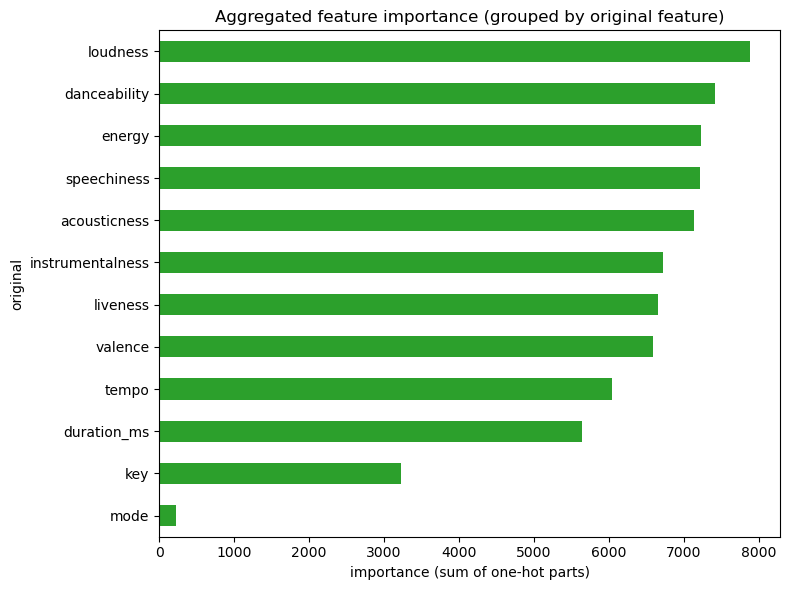

In [15]:
# 원-핫 컬럼 → 원래 컬럼 매핑 (예: 'key_0' -> 'key')
def original_col(name):
    # '_'로 분리한 첫 토큰이 원래 컬럼명(cat_cols에 포함)이라 가정
    if '_' in name:
        base = name.split('_')[0]
        if base in cat_cols:
            return base
    # 숫자형 피처는 그대로 반환
    return name

mapped = [original_col(n) for n in feature_names]

# 그룹 합산 (범주형 원-핫 컬럼은 같은 원컬럼으로 합산)
df_imp = pd.DataFrame({'feature': feature_names, 'original': mapped, 'imp': lgb_importances.values})

grouped = df_imp.groupby('original', sort=False)['imp'].sum().sort_values(ascending=False)

print('\n=== Aggregated importances (original features) ===')
print(grouped.head(20))

plt.figure(figsize=(8,6))
grouped.head(20).sort_values().plot.barh(color='C2')
plt.title('Aggregated feature importance (grouped by original feature)')
plt.xlabel('importance (sum of one-hot parts)')
plt.tight_layout()
plt.show()